In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 340

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 0

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

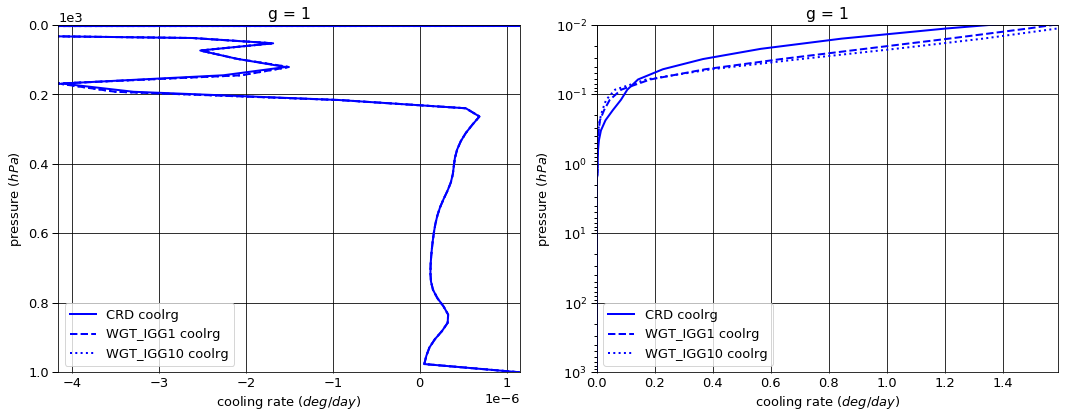

# Figure: cooling rate g-group 2

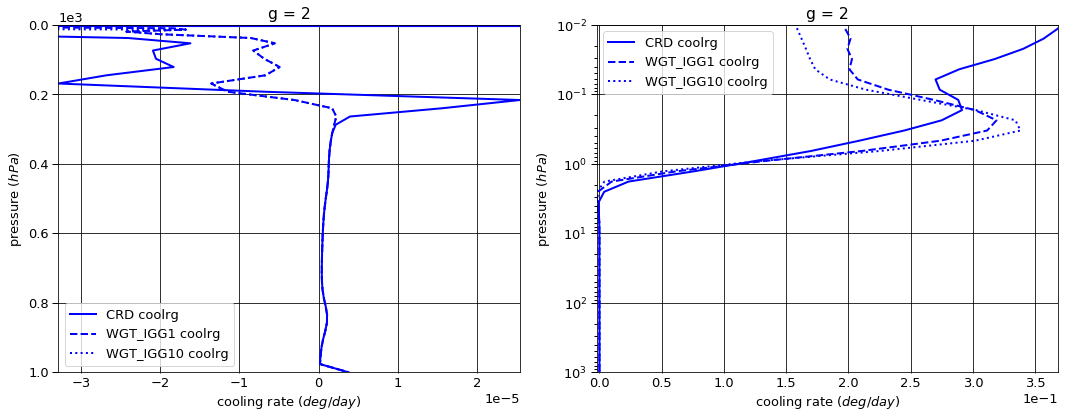

# Figure: cooling rate g-group 3

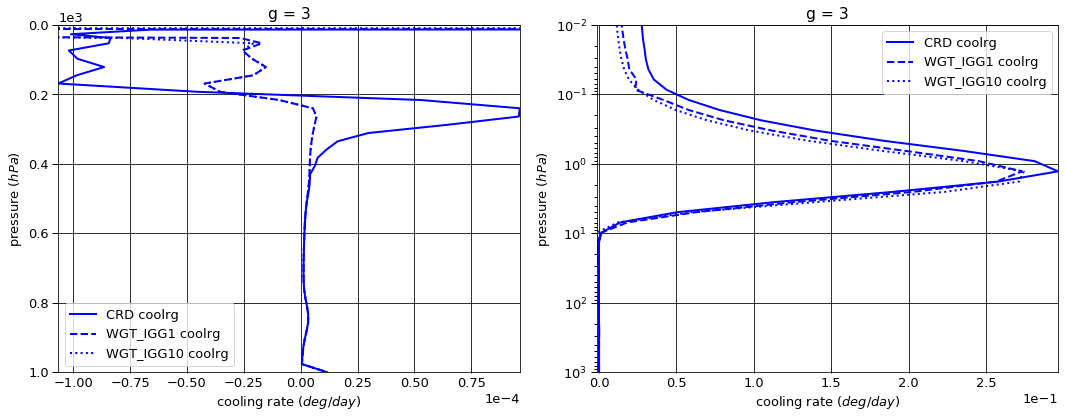

# Figure: cooling rate g-group 4

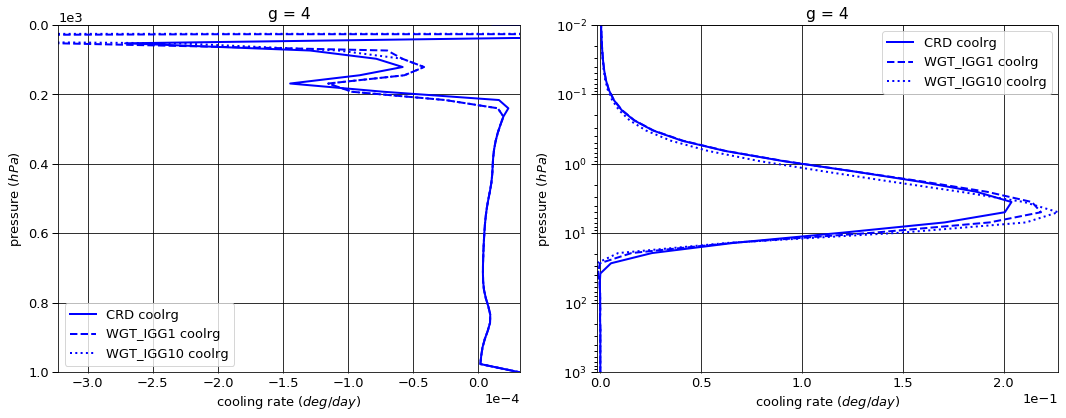

# Figure: cooling rate g-group 5

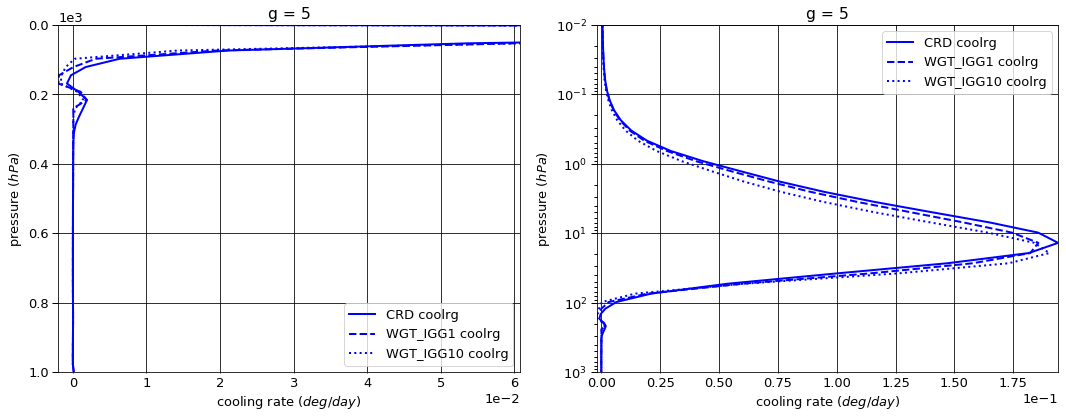

# Figure: cooling rate g-group 6

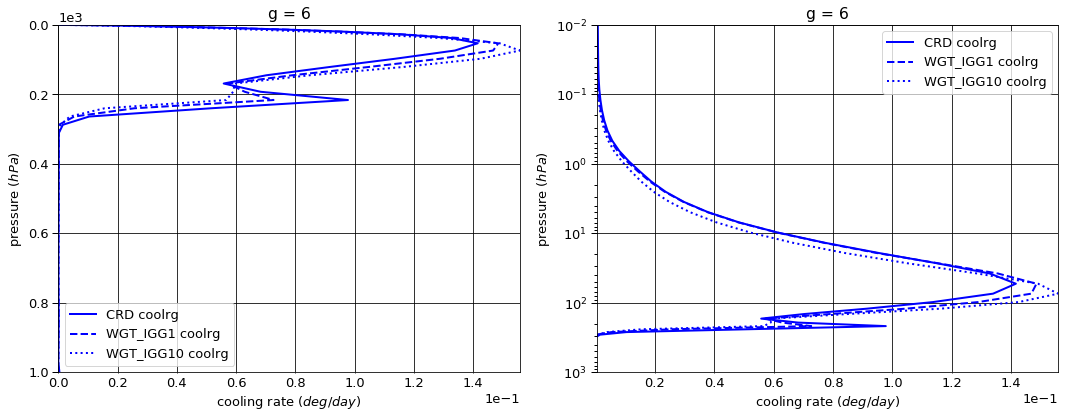

# Figure: cooling rate g-group 7

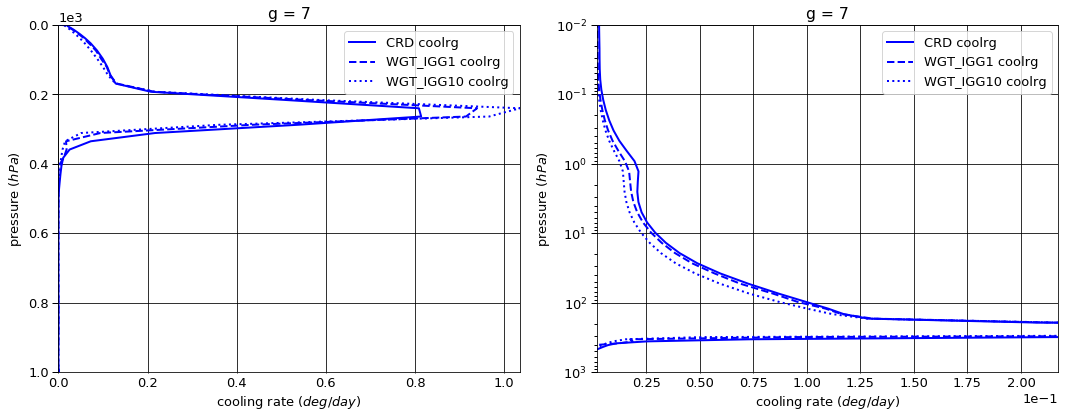

# Figure: cooling rate g-group 8

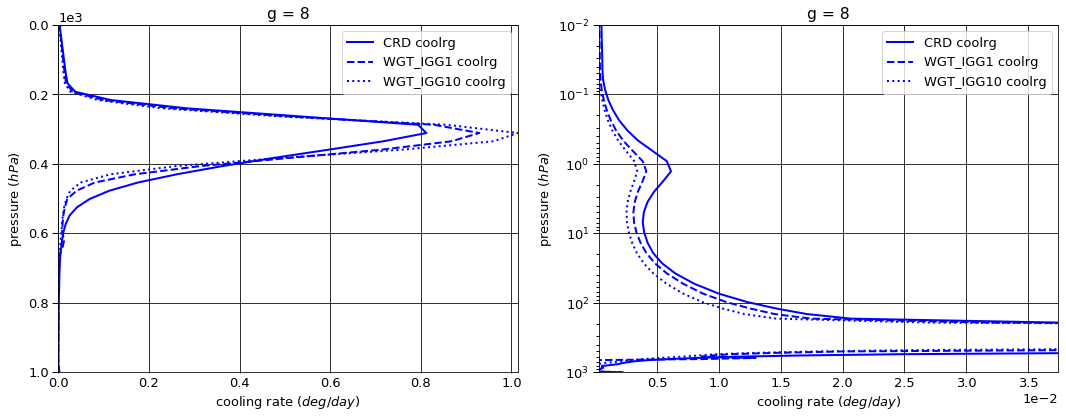

# Figure: cooling rate g-group 9

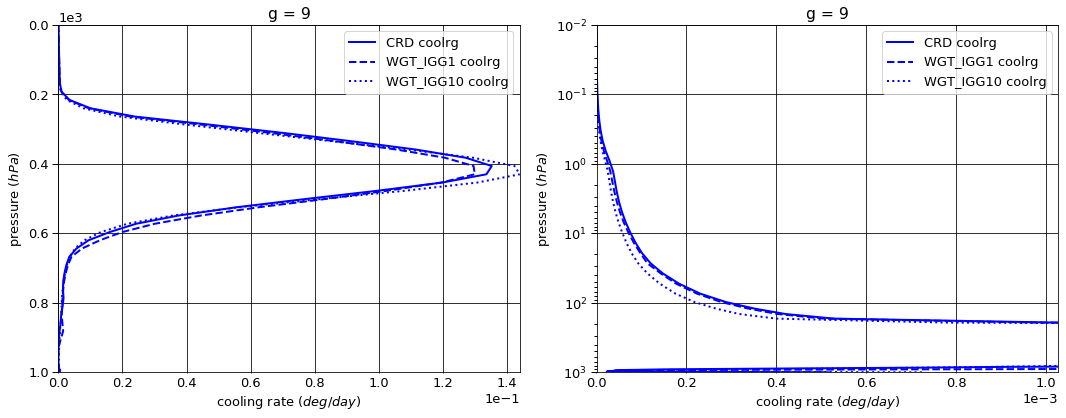

# Figure: cooling rate g-group 10

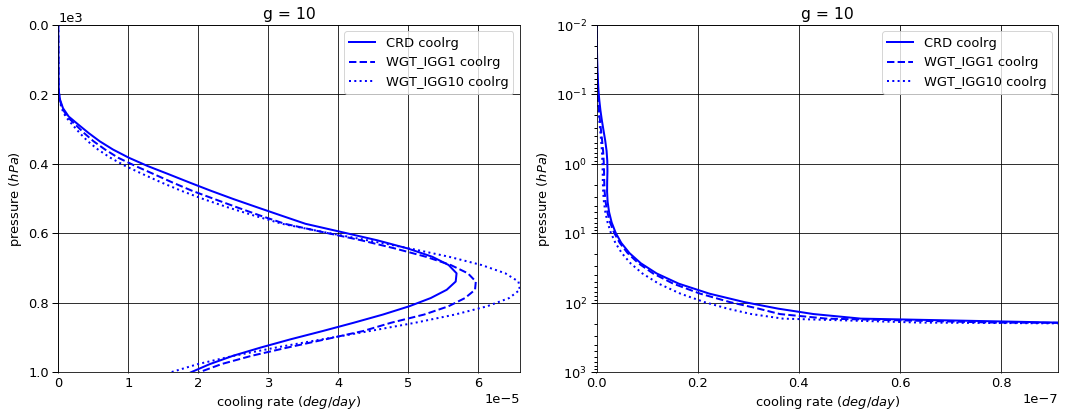

# Figure: cooling rate g-group total

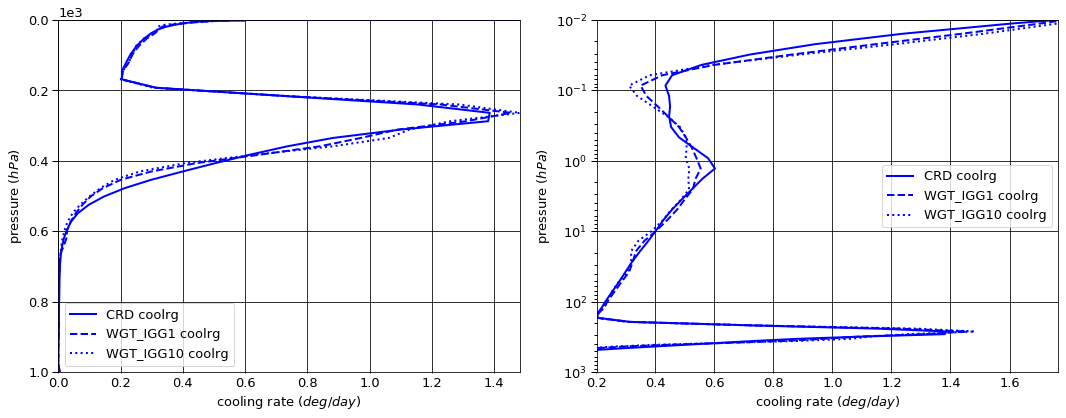

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007551   0.000000  -0.007551
   1013.0   76     -0.012813   0.012810  -0.000003
2  0.0      1      -0.030835   0.000000  -0.030835
   1013.0   76     -0.041368   0.041357  -0.000010
3  0.0      1      -0.106051   0.000000  -0.106051
   1013.0   76     -0.129677   0.129645  -0.000032
4  0.0      1      -0.265090   0.000000  -0.265090
   1013.0   76     -0.359444   0.359356  -0.000088
5  0.0      1      -0.945601   0.000000  -0.945601
   1013.0   76     -1.461188   1.460829  -0.000359
6  0.0      1      -2.755924   0.000000  -2.755924
   1013.0   76     -4.528739   4.527633  -0.001107
7  0.0      1     -10.995371   0.000000 -10.995371
   1013.0   76    -17.083986  17.079768  -0.004218
8  0.0      1     -15.704244   0.000000 -15.704244
   1013.0   76    -22.716969  22.710865  -0.006104
9  0.0      1      -3.434774   0.000000  -3.434774
   1013.0   76     -4.755700   4.754271  -0.001429
10 0.0      1      -0.003002   0.000000  -0.003002
   1013.0   76     -0.003190   0.002991  -0.000199


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007448   0.000000  -0.007448
   1013.0   76     -0.012813   0.012810  -0.000003
2  0.0      1      -0.031220   0.000000  -0.031220
   1013.0   76     -0.041368   0.041357  -0.000010
3  0.0      1      -0.106160   0.000000  -0.106160
   1013.0   76     -0.129677   0.129645  -0.000032
4  0.0      1      -0.267207   0.000000  -0.267207
   1013.0   76     -0.359444   0.359356  -0.000088
5  0.0      1      -0.943762   0.000000  -0.943762
   1013.0   76     -1.461188   1.460829  -0.000359
6  0.0      1      -2.742143   0.000000  -2.742143
   1013.0   76     -4.528739   4.527633  -0.001107
7  0.0      1     -10.918088   0.000000 -10.918088
   1013.0   76    -17.083986  17.079768  -0.004218
8  0.0      1     -15.569977   0.000000 -15.569977
   1013.0   76    -22.716969  22.710865  -0.006104
9  0.0      1      -3.451801   0.000000  -3.451801
   1013.0   76     -4.755700   4.754289  -0.001411
10 0.0      1      -0.003010   0.000000  -0.003010
   1013.0   76     -0.003190   0.003031  -0.000159


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007430   0.000000  -0.007430
   1013.0   76     -0.012813   0.012810  -0.000003
2  0.0      1      -0.031220   0.000000  -0.031220
   1013.0   76     -0.041368   0.041357  -0.000010
3  0.0      1      -0.106658   0.000000  -0.106658
   1013.0   76     -0.129677   0.129645  -0.000032
4  0.0      1      -0.267320   0.000000  -0.267320
   1013.0   76     -0.359444   0.359356  -0.000088
5  0.0      1      -0.942686   0.000000  -0.942686
   1013.0   76     -1.461188   1.460829  -0.000359
6  0.0      1      -2.732592   0.000000  -2.732592
   1013.0   76     -4.528739   4.527633  -0.001107
7  0.0      1     -10.905856   0.000000 -10.905856
   1013.0   76    -17.083986  17.079768  -0.004218
8  0.0      1     -15.551367   0.000000 -15.551367
   1013.0   76    -22.716969  22.710865  -0.006104
9  0.0      1      -3.447005   0.000000  -3.447005
   1013.0   76     -4.755700   4.753847  -0.001853
10 0.0      1      -0.003011   0.000000  -0.003011
   1013.0   76     -0.003190   0.003094  -0.000096


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.032101e-04  0.000000  1.032101e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -3.855880e-04  0.000000 -3.855880e-04
   1013.0   76     0.000000e+00  0.000000 -1.694066e-21
3  0.0      1     -1.095200e-04  0.000000 -1.095200e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1     -2.117170e-03  0.000000 -2.117170e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      1.839080e-03  0.000000  1.839080e-03
   1013.0   76    -2.220446e-16  0.000000  0.000000e+00
6  0.0      1      1.378110e-02  0.000000  1.378110e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      7.728300e-02  0.000000  7.728300e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      1.342670e-01  0.000000  1.342670e-01
   1013.0   76     0.000000e+00  0.000000  8.570000e-08
9  0.0      1     -1.702690e-02  0.000000 -1.702690e-02
   1013.0   76     0.000000e+00  0.000018  1.766220e-05
10 0.0      1     -8.752800e-06  0.000000 -8.752800e-06
   1013.0   76     0.000000e+00  0.000040  4.027884e-05


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.210122e-04  0.000000  1.210122e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
2  0.0      1     -3.854820e-04  0.000000 -3.854820e-04
   1013.0   76     0.000000e+00  0.000000 -1.694066e-21
3  0.0      1     -6.072100e-04  0.000000 -6.072100e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1     -2.229840e-03  0.000000 -2.229840e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      2.914430e-03  0.000000  2.914430e-03
   1013.0   76    -2.220446e-16  0.000000  0.000000e+00
6  0.0      1      2.333270e-02  0.000000  2.333270e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      8.951500e-02  0.000000  8.951500e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      1.528770e-01  0.000000  1.528770e-01
   1013.0   76     0.000000e+00  0.000000  8.570000e-08
9  0.0      1     -1.223050e-02  0.000000 -1.223050e-02
   1013.0   76     0.000000e+00 -0.000424 -4.239069e-04
10 0.0      1     -9.327400e-06  0.000000 -9.327400e-06
   1013.0   76     0.000000e+00  0.000103  1.029554e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.811306e+00
   1001.112500 75     1.152206e-06
2  0.000312    1      3.568864e-01
   1001.112500 75     3.788209e-06
3  0.000312    1      2.269207e-02
   1001.112500 75     1.170742e-05
4  0.000312    1      1.125224e-05
   1001.112500 75     3.176562e-05
5  0.000312    1      3.287643e-04
   1001.112500 75     1.298963e-04
6  0.000312    1      7.261503e-04
   1001.112500 75     4.002050e-04
7  0.000312    1      2.646510e-03
   1001.112500 75     1.525468e-03
8  0.000312    1      3.944442e-04
   1001.112500 75     2.207108e-03
9  0.000312    1      7.630160e-07
   1001.112500 75     5.168940e-04
10 0.000312    1      1.348572e-12
   1001.112500 75     1.894982e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.653669e+00
   1001.112500 75     1.152206e-06
2  0.000312    1      1.710090e-01
   1001.112500 75     3.788209e-06
3  0.000312    1      1.108822e-02
   1001.112500 75     1.170742e-05
4  0.000312    1      1.136372e-05
   1001.112500 75     3.176562e-05
5  0.000312    1      2.909476e-04
   1001.112500 75     1.298963e-04
6  0.000312    1      4.104005e-04
   1001.112500 75     4.002050e-04
7  0.000312    1      1.832825e-03
   1001.112500 75     1.525468e-03
8  0.000312    1      2.644216e-04
   1001.112500 75     2.207075e-03
9  0.000312    1      4.746762e-07
   1001.112500 75     5.101188e-04
10 0.000312    1      1.313392e-12
   1001.112500 75     2.011266e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.251303e+00
   1001.112500 75     1.152206e-06
2  0.000312    1      1.302986e-01
   1001.112500 75     3.788209e-06
3  0.000312    1      8.540483e-03
   1001.112500 75     1.170742e-05
4  0.000312    1      1.001457e-05
   1001.112500 75     3.176562e-05
5  0.000312    1      2.533228e-04
   1001.112500 75     1.298963e-04
6  0.000312    1      3.482224e-04
   1001.112500 75     4.002050e-04
7  0.000312    1      1.502796e-03
   1001.112500 75     1.525468e-03
8  0.000312    1      2.115485e-04
   1001.112500 75     2.207075e-03
9  0.000312    1      3.656302e-07
   1001.112500 75     7.299919e-04
10 0.000312    1      1.072994e-12
   1001.112500 75     1.606478e-05


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.157637e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.858774e-01
   1001.112500 75    -4.235165e-22
3  0.000312    1     -1.160385e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      1.114820e-07
   1001.112500 75     0.000000e+00
5  0.000312    1     -3.781676e-05
   1001.112500 75    -2.710505e-20
6  0.000312    1     -3.157497e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -8.136847e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.300226e-04
   1001.112500 75    -3.310000e-08
9  0.000312    1     -2.883397e-07
   1001.112500 75    -6.775170e-06
10 0.000312    1     -3.518010e-14
   1001.112500 75     1.162837e-06


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.560003e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -2.265878e-01
   1001.112500 75    -4.235165e-22
3  0.000312    1     -1.415159e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.237668e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -7.544155e-05
   1001.112500 75    -2.710505e-20
6  0.000312    1     -3.779279e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.143714e-03
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.828957e-04
   1001.112500 75    -3.310000e-08
9  0.000312    1     -3.973858e-07
   1001.112500 75     2.130979e-04
10 0.000312    1     -2.755777e-13
   1001.112500 75    -2.885042e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.248442,0.000000,-34.248442
1013.0,76,-51.093074,51.079525,-0.013550



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.040816,0.000000,-34.040816
1013.0,76,-51.093074,51.079583,-0.013492



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.995144,0.000000,-33.995144
1013.0,76,-51.093074,51.079204,-0.013871



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.207625,0.000000,0.207625
1013.0,76,0.000000,0.000058,0.000058



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.253298,0.000000,0.253298
1013.0,76,0.000000,-0.000321,-0.000321


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.194992
1001.112500,75,0.004847



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.838577
1001.112500,75,0.004841



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.392468
1001.112500,75,0.005057



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.356415
1001.112500,75,-0.000006



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.802524
1001.112500,75,0.000210


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000255
2,0.000809,0.000817
3,0.002676,0.002572
4,0.008074,0.007174
5,0.032162,0.029113
6,0.102338,0.090400
7,0.370206,0.339949
8,0.370250,0.440484
9,0.082235,0.089165


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.248849e-17
2,5.727377e-18
3,4.525250e-19
4,1.010527e-18
5,8.064138e-20
6,6.317397e-20
7,5.065678e-21
8,4.061973e-22
9,3.257140e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.248849e-17,NaN,0.000294,0.000255,0.000294,0.000255,1.0
2,5.727377e-18,0.079011,0.000809,0.000817,0.001103,0.001071,1.0
3,4.525250e-19,0.079011,0.002676,0.002572,0.003779,0.003643,1.0
4,1.010527e-18,2.233086,0.008074,0.007174,0.011853,0.010817,30.0
5,8.064138e-20,0.079801,0.032162,0.029113,0.044015,0.039930,30.0
6,6.317397e-20,0.783394,0.102338,0.090400,0.146353,0.130331,300.0
7,5.065678e-21,0.080186,0.370206,0.339949,0.516559,0.470279,300.0
8,4.061973e-22,0.080186,0.370250,0.440484,0.886809,0.910764,300.0
9,3.257140e-23,0.080186,0.082235,0.089165,0.969044,0.999929,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.381695e-16  1.081206e-16   3.127706  1.508504e-02
      2  0.000312     8.628104e-18  3.286063e-18   2.625666  4.163252e-04
      3  0.000312     2.464532e-19  6.993324e-20   3.524121  1.046539e-05
      4  0.000312     3.886856e-23  3.886780e-23   1.000020  3.310046e-09
      5  0.000312     2.584582e-22  1.654222e-22   1.562415  1.646446e-08
      6  0.000312     1.507214e-22  4.688939e-23   3.214402  6.645890e-09
      7  0.000312     1.526876e-22  1.454779e-23  10.495586  8.297394e-09
      8  0.000312     2.175456e-23  1.113665e-24  19.534200  1.149522e-09
      9  0.000312     2.384022e-25  6.097106e-26   3.910089  1.425851e-11
      10 0.000312     3.772955e-28  3.614792e-28   1.043754  3.159214e-14
2     1  0.000750     3.386803e-16  1.083533e-16   3.125704  6.086897e-03
      2  0.000750     8.674357e-18  3.300222e-18   2.628417  1.685062e-04
      3  0.000750     2.476846e-19  7.072296e-20   3.502181  4.246953e-06
      4  0.000750     9.240914e-23  9.240577e-23   1.000036  3.169717e-09
      5  0.000750     2.644237e-22  1.708857e-22   1.547372  6.824238e-09
      6  0.000750     1.511365e-22  4.735515e-23   3.191553  2.692331e-09
      7  0.000750     1.530730e-22  1.462847e-23  10.464047  3.351119e-09
      8  0.000750     2.188199e-23  1.121156e-24  19.517345  4.657376e-10
      9  0.000750     2.406448e-25  6.161800e-26   3.905431  5.798170e-12
      10 0.000750     8.987065e-28  8.133831e-28   1.104900  2.965653e-14
3     1  0.001052     3.397538e-16  1.087375e-16   3.124530  8.564609e-03
      2  0.001052     8.767032e-18  3.320879e-18   2.639973  2.383437e-04
      3  0.001052     2.495883e-19  7.157576e-20   3.487051  6.012055e-06
      4  0.001052     1.293949e-22  1.293885e-22   1.000049  6.224238e-09
      5  0.001052     2.704769e-22  1.759049e-22   1.537631  9.826582e-09
      6  0.001052     1.515760e-22  4.786513e-23   3.166731  3.799202e-09
      7  0.001052     1.538380e-22  1.473510e-23  10.440241  4.723690e-09
      8  0.001052     2.214929e-23  1.131206e-24  19.580239  6.610522e-10
      9  0.001052     2.449085e-25  6.239627e-26   3.925051  8.269307e-12
      10 0.001052     1.254579e-27  1.093325e-27   1.147490  5.724784e-14
4     1  0.001476     3.408873e-16  1.091620e-16   3.122764  1.205822e-02
      2  0.001476     8.866857e-18  3.344251e-18   2.651373  3.374955e-04
      3  0.001476     2.517472e-19  7.261524e-20   3.466864  8.527076e-06
      4  0.001476     1.812932e-22  1.812809e-22   1.000068  1.223402e-08
      5  0.001476     2.780543e-22  1.823369e-22   1.524948  1.424289e-08
      6  0.001476     1.521207e-22  4.848852e-23   3.137251  5.370345e-09
      7  0.001476     1.546708e-22  1.485877e-23  10.409395  6.663890e-09
      8  0.001476     2.243715e-23  1.142840e-24  19.632803  9.393548e-10
      9  0.001476     2.495761e-25  6.332652e-26   3.941099  1.181505e-11
      10 0.001476     1.751723e-27  1.450225e-27   1.207897  1.100767e-13
5     1  0.002070     3.420194e-16  1.096158e-16   3.120166  1.697491e-02
      2  0.002070     8.969143e-18  3.370129e-18   2.661365  4.779859e-04
      3  0.002070     2.541293e-19  7.387925e-20   3.439792  1.211136e-05
      4  0.002070     2.541153e-22  2.540915e-22   1.000093  2.405140e-08
      5  0.002070     2.875191e-22  1.905943e-22   1.508540  2.079277e-08
      6  0.002070     1.527928e-22  4.924716e-23   3.102572  7.601729e-09
      7  0.002070     1.555348e-22  1.500015e-23  10.368881  9.401104e-09
      8  0.002070     2.273096e-23  1.156097e-24  19.661813  1.334715e-09
      9  0.002070     2.544625e-25  6.442967e-26   3.949462  1.689091e-11
      10 0.002070     2.446570e-27  1.890957e-27   1.293826  2.105408e-13
6     1  0.002904     3.431494e-16  1.101099e-16   3.116427  2.390229e-02
      2  0.002904     9.074448e-18  3.399514e-18   2.669337  6.774146e-04
      3  0.002904     2.568127e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
